# The German Credit XGBoost model

### The Data

The German Credit data set is a publically available data set downloaded from the UCI Machine Learning Repository. The data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.

#### [Data Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))
- Professor Dr. Hans Hofmann  
- Institut f"ur Statistik und "Okonometrie  
- Universit"at Hamburg  
- FB Wirtschaftswissenschaften  
- Von-Melle-Park 5    
- 2000 Hamburg 13

### Import Library

In [1]:
#Importing necessary packages in Python 
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd

from sklearn.datasets import make_classification 
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

import warnings 
warnings.filterwarnings("ignore", category=UserWarning) 

import xgboost as xgb
from xgboost import XGBClassifier

from macest.classification import models as clmod
from macest.classification import plots as clplot

Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


### Evaluation Function


In [2]:
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return


### Preprocess
- Importing Dataset
- StandardScaler
- Encoding Categorical Feature
- Concate Transformed Dataset
- Split Training Dataset
- XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
- XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

### Import Dataset

OK let's get started. We'll download the data from the UCI website.

In [3]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv(url, names = names, delimiter=' ')
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [4]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

### StandardScaler

In [5]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

### Encoding Categorical Feature

Labelencoding to transform categorical to numerical, Enables better Visualization than one hot encoding

In [6]:
from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


### Concate Transformed Dataset
append the dummy variable of the initial numerical variables numvars# append 

In [7]:
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 62)


### Split The Dataset

In [8]:
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']


X_train, X_conf_train, y_train, y_conf_train  = train_test_split(X_clean, y_clean, 
                                                                 test_size=0.6, random_state=10)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.5, random_state=0)

X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, 
                                                  test_size=0.5, random_state=0)

In [9]:
print('X_train, y_train:', np.shape(X_train), np.shape(y_train))
print('X_test, y_test:', np.shape(X_test), np.shape(y_test))

print('X_conf_train, y_conf_train:', np.shape(X_conf_train), np.shape(y_conf_train))
print('X_cal, y_cal:', np.shape(X_cal), np.shape(y_cal))

X_train, y_train: (400, 61) (400,)
X_test, y_test: (150, 61) (150,)
X_conf_train, y_conf_train: (300, 61) (300,)
X_cal, y_cal: (150, 61) (150,)


### XGBoost  Training (ROC_AUC:0.79)

In [10]:
params={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

eval_set=[(X_train, y_train), (X_test, y_test)]
model = XGBClassifier(**params)

In [11]:
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', early_stopping_rounds = 100, verbose=1000)
model.set_params(**{'n_estimators': model.best_ntree_limit})

[0]	validation_0-auc:0.75624	validation_1-auc:0.68004
[274]	validation_0-auc:0.91452	validation_1-auc:0.79309


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=176, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.555,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

### XGBoost Predictions

In [12]:
xgboost_preds = model.predict(X_test, ntree_limit=model.best_ntree_limit)

# Confidence Model For The German Credit XGBoost model

In [13]:
from src.FPR_FNR_TRADEOFF.fft_model import FprFnrTradeoffModel

In [14]:
from macest.classification import models as clmod
from macest.classification import plots as clplot

Setting the confidence model hyperparameters

(Optimiser args are the arguments passed to scipy differential evolution and must be passed as a dictionary)

In [15]:
param_bounds = clmod.SearchBounds(k_bounds = (5,50))
neighbour_search_params = clmod.HnswGraphArgs(init_args = dict(method = 'hnsw',
                                                               space = 'kldivfast'), 
                                              query_args = dict(ef = 4000))
optimiser_args = dict(popsize = 100)

Training MACEst Confidence model

In [16]:
tradeoff_model = FprFnrTradeoffModel(
    point_pred_model=model,
    x_train=X_conf_train,
    y_train=y_conf_train, 
    threshold=0.7,
    search_method_args=neighbour_search_params
)

tradeoff_model.fit(X_cal, np.array(y_cal), param_range=param_bounds, optimiser_args=optimiser_args)

In [17]:
xgboost_conf_preds = model.predict_proba(X_test)
macest_point_prediction_conf = tradeoff_model.predict_confidence_of_point_prediction(X_test)                             
xgboost_point_prediction_conf = np.amax(xgboost_conf_preds, axis=1)

### Let's compare calibration and forecast metrics

In [18]:
from macest.classification.metrics import expected_calibration_error

xgboost_expected_calibration_error = expected_calibration_error(xgboost_preds, y_test, xgboost_point_prediction_conf)
macest_expected_calibration_error = expected_calibration_error(xgboost_preds, y_test, macest_point_prediction_conf)

print('xgboost_expected_calibration_error', xgboost_expected_calibration_error)
print('macest_expected_calibration_error', macest_expected_calibration_error)

xgboost_expected_calibration_error 15.00742359956106
macest_expected_calibration_error 12.98116460257627


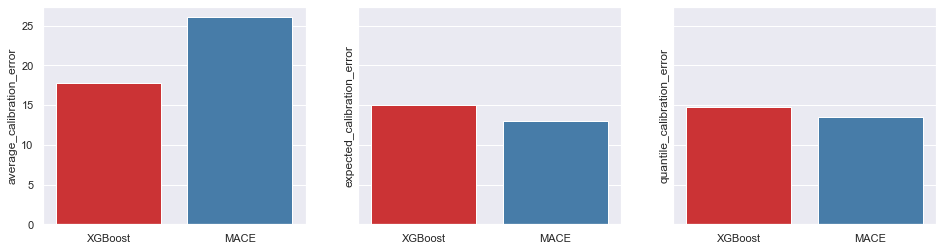

In [19]:
clplot.plot_calibration_metrics([xgboost_point_prediction_conf, 
                                macest_point_prediction_conf], 
                              ['XGBoost','MACE'], xgboost_preds, y_test)

### FPR FNR Tradeoff Performance

In [20]:
tradeoff_preds = tradeoff_model.predict_with_tradeoff(xgboost_preds, X_test)

In [21]:
print('Base Model accuracy:', FprFnrTradeoffModel._calc_accuracy(y_test, xgboost_preds))
print('Base Model recall:', FprFnrTradeoffModel._calc_recall(y_test, xgboost_preds))
print('Base Model Precision:', FprFnrTradeoffModel._calc_precision(y_test, xgboost_preds))
print('Base Model FPR & FNR:', FprFnrTradeoffModel._calc_fpr_fnr(y_test, xgboost_preds)[0], FprFnrTradeoffModel._calc_fpr_fnr(y_test, xgboost_preds)[1])

Base Model accuracy: 0.76
Base Model recall: 0.9306930693069307
Base Model Precision: 0.7642276422764228
Base Model FPR & FNR: 0.5918367346938775 0.06930693069306931


In [22]:
print('Accuracy:', FprFnrTradeoffModel._calc_accuracy(y_test, tradeoff_preds))
print('Recall:', FprFnrTradeoffModel._calc_recall(y_test, tradeoff_preds))
print('Precision:', FprFnrTradeoffModel._calc_precision(y_test, tradeoff_preds))
print('FPR & FNR:', FprFnrTradeoffModel._calc_fpr_fnr(y_test, tradeoff_preds)[0], FprFnrTradeoffModel._calc_fpr_fnr(y_test, tradeoff_preds)[1])

Accuracy: 0.7333333333333333
Recall: 0.8712871287128713
Precision: 0.7652173913043478
FPR & FNR: 0.5510204081632653 0.12871287128712872


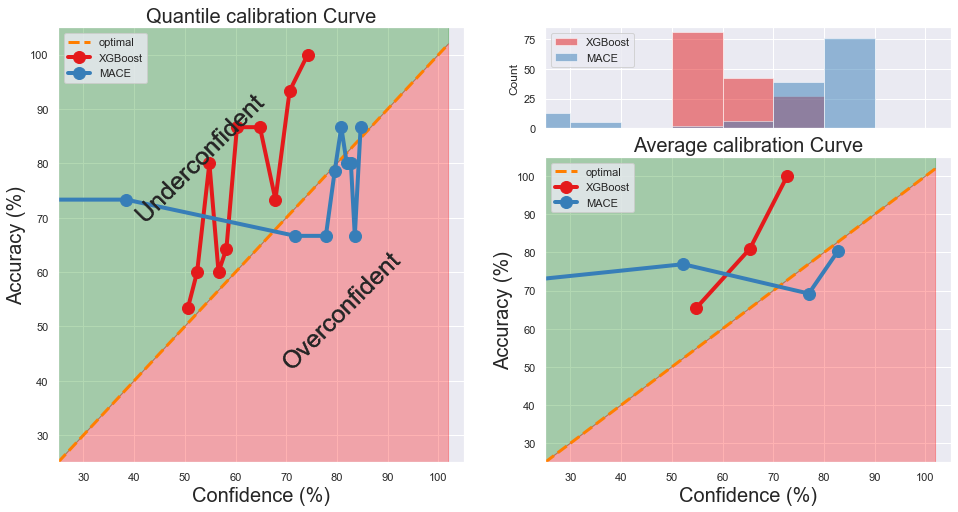

In [23]:
clplot.plot_calibration_curve([xgboost_point_prediction_conf,
                               macest_point_prediction_conf], 
                              ['XGBoost', 'MACE'],
                              xgboost_preds,
                              y_test)